In [1]:
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2019-CS109B/master/content/styles/cs109.css").text
HTML(styles)

In [1]:
import pandas as pd 
import numpy as np
import os 
from tqdm import tqdm
import seaborn as sns 
import matplotlib.pyplot as plt 
import sklearn 
import pygam 
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
from multiprocessing import Process,Array
%matplotlib inline 

In [2]:
data1 = pd.read_csv('./driver.csv')
data1.describe()

,id,vehicle_year
count,54681.000000,13223.000000
mean,27341.000000,2010.568025
std,15785.189372,35.219184
min,1.000000,0.000000
25%,13671.000000,2008.000000
50%,27341.000000,2013.000000
75%,41011.000000,2015.000000
max,54681.000000,2017.000000


In [3]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54681 entries, 0 to 54680
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    54681 non-null  int64  
 1   city_name             54681 non-null  object 
 2   signup_os             47824 non-null  object 
 3   signup_channel        54681 non-null  object 
 4   signup_date           54681 non-null  object 
 5   bgc_date              32896 non-null  object 
 6   vehicle_added_date    13134 non-null  object 
 7   vehicle_make          13223 non-null  object 
 8   vehicle_model         13223 non-null  object 
 9   vehicle_year          13223 non-null  float64
 10  first_completed_date  6137 non-null   object 
dtypes: float64(1), int64(1), object(9)
memory usage: 4.6+ MB


In [4]:
data1 

,id,city_name,signup_os,signup_channel,signup_date,bgc_date,vehicle_added_date,vehicle_make,vehicle_model,vehicle_year,first_completed_date
0,1,Strark,ios web,Paid,1/2/16,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Strark,windows,Paid,1/21/16,NaN,NaN,NaN,NaN,NaN,NaN
2,3,Wrouver,windows,Organic,1/11/16,1/11/16,NaN,NaN,NaN,NaN,NaN
3,4,Berton,android web,Referral,1/29/16,2/3/16,2/3/16,Toyota,Corolla,2016.0,2/3/16
4,5,Strark,android web,Referral,1/10/16,1/25/16,1/26/16,Hyundai,Sonata,2016.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
54676,54677,Strark,other,Paid,1/15/16,NaN,NaN,NaN,NaN,NaN,NaN
54677,54678,Strark,other,Paid,1/21/16,NaN,NaN,NaN,NaN,NaN,NaN
54678,54679,Strark,ios web,Organic,1/6/16,NaN,NaN,NaN,NaN,NaN,NaN
54679,54680,Berton,android web,Paid,1/18/16,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
data1[['signup_os','signup_channel']] = data1[['signup_os','signup_channel']].fillna('other')
start = list(map(lambda x: 1 if (str(x)!='nan') else 0,data1['first_completed_date']))
data1['start'] = pd.Series(start)
data1['vehicle_make'] = data1['vehicle_make'].fillna(data1.vehicle_make.mode()[0])
data1['vehicle_model'] = data1['vehicle_model'].fillna(data1.vehicle_model.mode()[0])
data1['vehicle_year'] = data1['vehicle_year'].fillna(data1.vehicle_year.mode()[0])
ifbgc =  list(map(lambda x: 1 if (str(x)!='nan') else 0,data1['bgc_date']))
data1['ifbgc'] = pd.Series(ifbgc)
ifadd =  list(map(lambda x: 1 if (str(x)!='nan') else 0,data1['vehicle_added_date']))
data1['ifadd'] = pd.Series(ifadd)
bgc_sign = pd.DataFrame(pd.to_datetime(data1['bgc_date']) - pd.to_datetime(data1['signup_date']))/pd.Timedelta(1,'D')
data1['bgc-sign'] = bgc_sign.fillna(69)
add_sign = pd.DataFrame(pd.to_datetime(data1['vehicle_added_date']) - pd.to_datetime(data1['signup_date']))/pd.Timedelta(1,'D')
data1['add-sign'] = add_sign.fillna(69)

In [6]:
bgc_sign.max()

0    69.0
dtype: float64

In [7]:
def get_dumvar(data,need):
    data_a = data.loc[:,need]
    cs = data_a.columns
    dums = [0]*len(cs)
    data_b = pd.DataFrame()
    for c in range(len(cs)):
        dums[c] = pd.get_dummies(data_a[cs[c]],prefix=cs[c]).iloc[:,:]
    data_b = pd.concat(dums,axis=1)
    return data_b 

In [8]:
dum_data = get_dumvar(data1,['city_name','signup_os','signup_channel','vehicle_make'])

In [9]:
data_prd = pd.concat([dum_data,data1],axis=1)

In [10]:
data_prd

,city_name_Berton,city_name_Strark,city_name_Wrouver,signup_os_android web,signup_os_ios web,signup_os_mac,signup_os_other,signup_os_windows,signup_channel_Organic,signup_channel_Paid,...,vehicle_added_date,vehicle_make,vehicle_model,vehicle_year,first_completed_date,start,ifbgc,ifadd,bgc-sign,add-sign
0,0,1,0,0,1,0,0,0,0,1,...,NaN,Toyota,Civic,2015.0,NaN,0,0,0,69.0,69.0
1,0,1,0,0,0,0,0,1,0,1,...,NaN,Toyota,Civic,2015.0,NaN,0,0,0,69.0,69.0
2,0,0,1,0,0,0,0,1,1,0,...,NaN,Toyota,Civic,2015.0,NaN,0,1,0,0.0,69.0
3,1,0,0,1,0,0,0,0,0,0,...,2/3/16,Toyota,Corolla,2016.0,2/3/16,1,1,1,5.0,5.0
4,0,1,0,1,0,0,0,0,0,0,...,1/26/16,Hyundai,Sonata,2016.0,NaN,0,1,1,15.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54676,0,1,0,0,0,0,1,0,0,1,...,NaN,Toyota,Civic,2015.0,NaN,0,0,0,69.0,69.0
54677,0,1,0,0,0,0,1,0,0,1,...,NaN,Toyota,Civic,2015.0,NaN,0,0,0,69.0,69.0
54678,0,1,0,0,1,0,0,0,1,0,...,NaN,Toyota,Civic,2015.0,NaN,0,0,0,69.0,69.0
54679,1,0,0,1,0,0,0,0,0,1,...,NaN,Toyota,Civic,2015.0,NaN,0,0,0,69.0,69.0


In [11]:
data_prd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54681 entries, 0 to 54680
Data columns (total 73 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   city_name_Berton            54681 non-null  uint8  
 1   city_name_Strark            54681 non-null  uint8  
 2   city_name_Wrouver           54681 non-null  uint8  
 3   signup_os_android web       54681 non-null  uint8  
 4   signup_os_ios web           54681 non-null  uint8  
 5   signup_os_mac               54681 non-null  uint8  
 6   signup_os_other             54681 non-null  uint8  
 7   signup_os_windows           54681 non-null  uint8  
 8   signup_channel_Organic      54681 non-null  uint8  
 9   signup_channel_Paid         54681 non-null  uint8  
 10  signup_channel_Referral     54681 non-null  uint8  
 11  vehicle_make_Acura          54681 non-null  uint8  
 12  vehicle_make_Audi           54681 non-null  uint8  
 13  vehicle_make_Autobot        546

# 1 Regression on whether drivers will start driving 

In [12]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay 
from sklearn.model_selection import train_test_split
from sklearn import linear_model


X = data_prd.drop(['id','city_name','signup_os','signup_channel','signup_date','bgc_date','vehicle_added_date','vehicle_make','vehicle_model','first_completed_date','start','ifbgc','ifadd'],axis=1)
y = data_prd['start']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)


train set: 0.9421830912321036
test set: 0.9419689119170984
Accuracy: 0.94
Precision: 0.72
Recall: 0.80
Average precision-recall score: 0.60
F1: 0.76
confusion matrix: [[46617  1927]
 [ 1238  4899]]


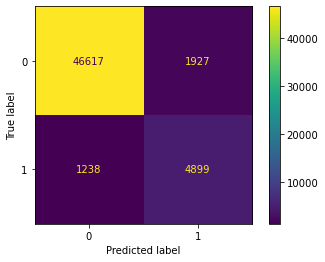

In [14]:

clf = linear_model.LogisticRegression(max_iter=10000000)
clf.fit(X_train,y_train)
print("train set:",clf.score(X_train,y_train))
print("test set:",clf.score(X_test,y_test))

clfcv = linear_model.LogisticRegressionCV(cv = 10,max_iter=1e9)
clfcv.fit(X,y)

def report_evaluation_metrics(y_true, y_pred):
    accuracy = sklearn.metrics.accuracy_score(y_true=y_true, y_pred=y_pred)
    precision = sklearn.metrics.precision_score(y_true=y_true, y_pred=y_pred, labels=[0, 1], pos_label=1)
    recall = sklearn.metrics.recall_score(y_true=y_true, y_pred=y_pred, labels=[0, 1], pos_label=1)
    average_precision = sklearn.metrics.average_precision_score(y_true=y_true, y_score=y_pred)
    f1 = sklearn.metrics.f1_score(y_true=y_true, y_pred=y_pred, labels=[0, 1], pos_label=1)
    conf_matrix = sklearn.metrics.confusion_matrix(y_true, y_pred)
    print('Accuracy: {0:0.2f}'.format(accuracy))
    print('Precision: {0:0.2f}'.format(precision))
    print('Recall: {0:0.2f}'.format(recall))
    print('Average precision-recall score: {0:0.2f}'.format(average_precision))
    print('F1: {0:0.2f}'.format(f1))
    print("confusion matrix:", conf_matrix)
    train_matrix = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=train_matrix,)
    disp.plot()

report_evaluation_metrics(y,clfcv.predict(X))

In [15]:
clfcv.coef_

array([[ 4.01002437e-02, -3.26002401e-02, -8.34169871e-03,
        -3.83872439e-02, -1.36514318e-02,  4.71512237e-02,
        -2.24302831e-02,  2.64760399e-02, -3.56171321e-02,
        -8.66487056e-02,  1.21424143e-01,  3.87181409e-03,
        -1.30144599e-03, -6.05305409e-04, -2.02024339e-03,
        -3.33427027e-04,  2.13440305e-06,  1.51889378e-04,
         6.79524051e-04, -5.71817027e-04, -1.35192962e-02,
        -4.79762879e-03, -7.26029746e-03,  1.28700315e-04,
        -7.08850202e-04,  2.36512788e-03,  1.88722280e-03,
         1.33805645e-04, -2.42009930e-03, -3.59474467e-03,
         1.07071483e-04, -4.32927210e-04, -2.00571618e-03,
        -5.60014548e-03, -1.93071378e-03,  6.16712922e-05,
         3.74458396e-04, -3.51207839e-05, -2.63395418e-03,
        -6.85381373e-04,  3.78447915e-04, -4.58118452e-04,
        -4.52034722e-03, -1.22148217e-02,  3.00905568e-04,
        -1.73755526e-03, -3.77763918e-04,  1.74675011e-04,
         1.25856858e-03,  3.04586082e-03, -6.16834853e-0

# Feature Selection

In [16]:
os.getcwd()

'/Users/zed/VSCode/regana/finnal-project'

In [17]:
res = pd.read_csv('./slt_ft.csv',index_col= 0)
res

,c,all,slt,all_recall,slt_recall
0,1.000000e-10,0.934657,0.898740,0.901906,0.119928
1,1.000000e-09,0.896509,0.898740,0.955840,0.119928
2,1.000000e-08,0.891882,0.898740,0.956166,0.119928
3,1.000000e-07,0.893126,0.898740,0.956166,0.119928
4,1.000000e-06,0.899161,0.898740,0.955840,0.119928
5,1.000000e-05,0.905836,0.926702,0.953397,0.453314
6,1.000000e-04,0.908780,0.932426,0.951442,0.907121
7,1.000000e-03,0.910005,0.914267,0.950139,0.947531
8,1.000000e-02,0.911231,0.911743,0.948672,0.948183
9,1.000000e-01,0.911596,0.855819,0.947857,0.721684


The best C-value for accuracy is 0.0001
THe best C-value for recall is: 0.0001


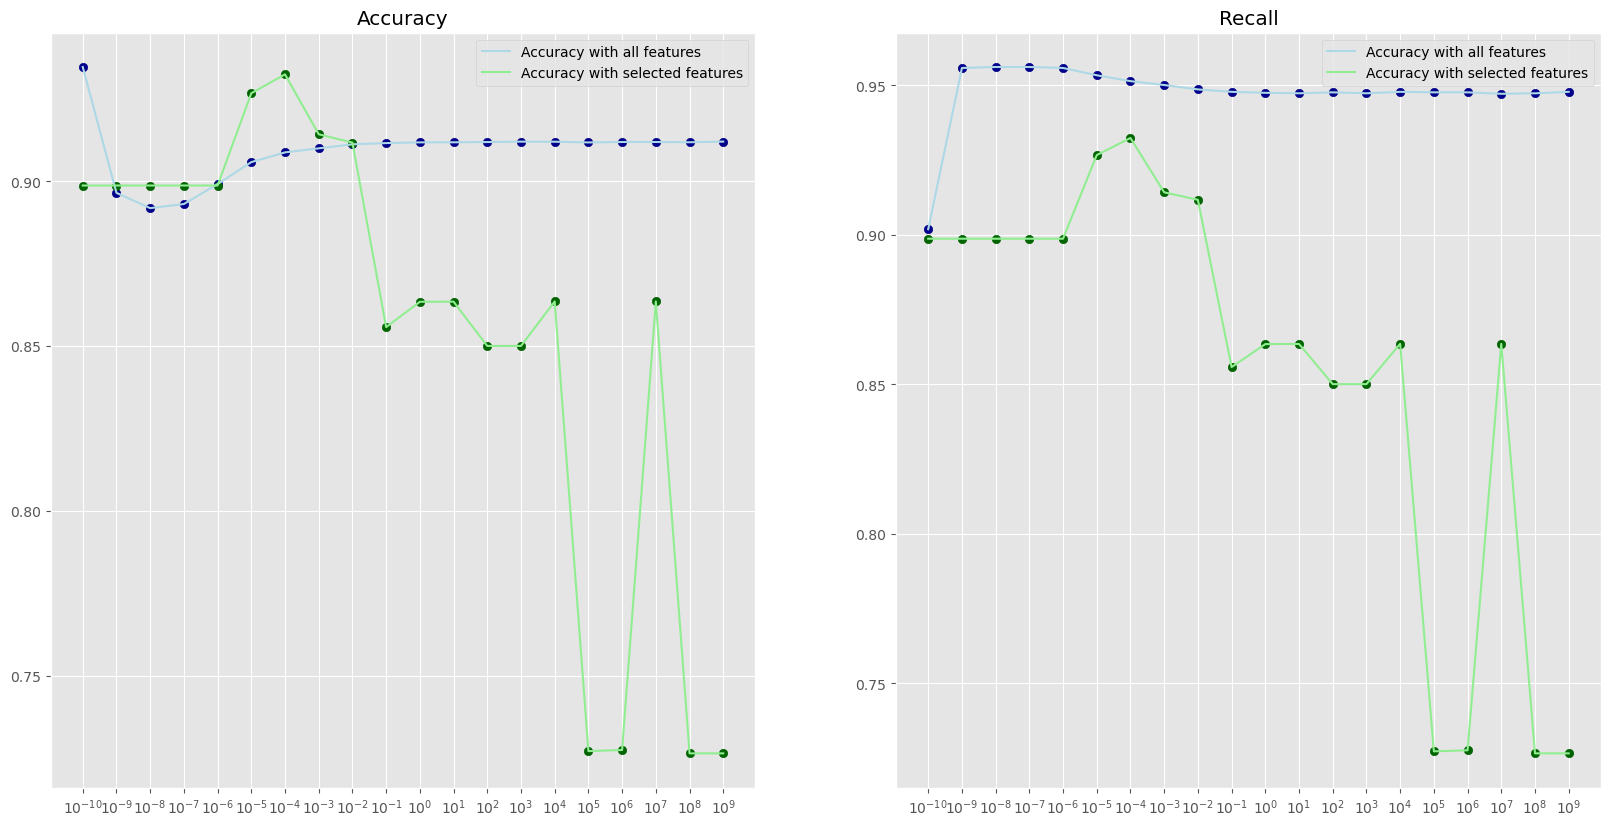

In [18]:
plt.style.use('ggplot')
fig,ax = plt.subplots(1,2,figsize = (20,10),dpi = 100,edgecolor = 'w')
for i in range(2):
    ax[i].set_xscale('log')

    ax[i].set_xticks(res['c'])
    if i==0: 
        ax[i].set_title('Accuracy')
        ax[i].plot(res.c,res['all'],c = 'lightblue',label = "Accuracy with all features")
        ax[i].scatter(res.c,res['all'],c = 'darkblue')
        ax[i].plot(res.c,res['slt'],c = 'lightgreen',label = 'Accuracy with selected features')        
        ax[i].scatter(res.c,res['slt'],c = 'darkgreen')
        id_ = res['slt'].idxmax()
        print('The best C-value for accuracy is',res.c[id_])
        ax[i].legend()
    else:
        ax[i].set_title('Recall')
        ax[i].plot(res.c,res['all_recall'],c = 'lightblue',label = "Accuracy with all features")
        ax[i].scatter(res.c,res['all_recall'],c = 'darkblue')
        ax[i].plot(res.c,res['slt'],c = 'lightgreen',label = 'Accuracy with selected features')        
        ax[i].scatter(res.c,res['slt'],c = 'darkgreen')
        id_ = res['slt'].idxmax()
        print('THe best C-value for recall is:',res.c[id_])
        ax[i].legend()
fig.savefig('slt.png')
        

In [19]:
from sklearn.feature_selection import SelectFromModel

lrvc = linear_model.LogisticRegression(C=1e-5,solver='liblinear',class_weight='balanced')

model  = SelectFromModel(
        estimator=lrvc, norm_order=1)
X_slt = model.fit_transform(X,y)
print(cross_val_score(lrvc,X_slt,y,scoring='accuracy',cv = 10).mean())
print(cross_val_score(lrvc,X_slt,y,scoring='recall',cv = 10).mean())


NameError: name 'cross_val_score' is not defined

In [ ]:
for i in range(len(model.get_support())):
    if model.get_support()[i] == 1:
        print(X.columns[i])

signup_channel_Paid
signup_channel_Referral
bgc-sign
add-sign


In [ ]:
sltlr = linear_model.LogisticRegression(solver='liblinear',C = 1e-05,class_weight='balanced')


In [ ]:
X_tr,X_te, y_tr, y_te = train_test_split(X_slt,y, test_size=0.3, random_state=0)

In [ ]:
lr = sltlr.fit(X_tr,y_tr)

In [ ]:
lr.score(X_te,y_te)

0.9217311795184395

Accuracy: 0.92
Precision: 0.39
Recall: 0.83
Average precision-recall score: 0.33
F1: 0.53
confusion matrix: [[14395  1133]
 [  151   726]]
Accuracy: 0.92
Precision: 0.39
Recall: 0.81
Average precision-recall score: 0.33
F1: 0.53
confusion matrix: [[33616  2611]
 [  382  1667]]


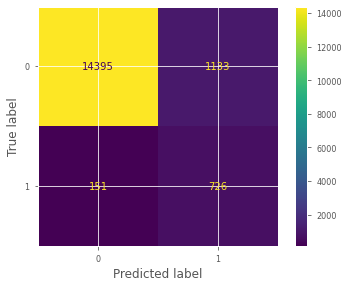

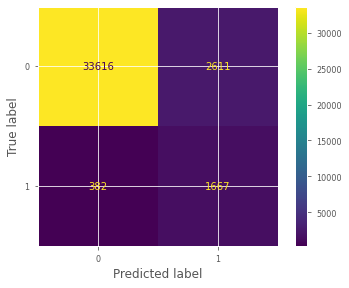

In [ ]:
report_evaluation_metrics(lr.predict(X_te),y_te)
report_evaluation_metrics(lr.predict(X_tr),y_tr)

# GAM

In [ ]:
N,F = X_train.shape

In [ ]:

formula = "f(0)"
for i in range(1,F):
    if i<=56:
        formula +="+f("+str(i)+")"
    else:
        formula += "+s("+str(i)+")"
print(formula)

f(0)+f(1)+f(2)+f(3)+f(4)+f(5)+f(6)+f(7)+f(8)+f(9)+f(10)+f(11)+f(12)+f(13)+f(14)+f(15)+f(16)+f(17)+f(18)+f(19)+f(20)+f(21)+f(22)+f(23)+f(24)+f(25)+f(26)+f(27)+f(28)+f(29)+f(30)+f(31)+f(32)+f(33)+f(34)+f(35)+f(36)+f(37)+f(38)+f(39)+f(40)+f(41)+f(42)+f(43)+f(44)+f(45)+f(46)+f(47)+f(48)+f(49)+f(50)+f(51)+f(52)+f(53)+f(54)+f(55)+f(56)+s(57)+s(58)+s(59)


In [ ]:
X_train.columns 

Index(['city_name_Berton', 'city_name_Strark', 'city_name_Wrouver',
       'signup_os_android web', 'signup_os_ios web', 'signup_os_mac',
       'signup_os_other', 'signup_os_windows', 'signup_channel_Organic',
       'signup_channel_Paid', 'signup_channel_Referral', 'vehicle_make_Acura',
       'vehicle_make_Audi', 'vehicle_make_Autobot', 'vehicle_make_BMW',
       'vehicle_make_Bentley', 'vehicle_make_Bicycle', 'vehicle_make_Bike',
       'vehicle_make_Buick', 'vehicle_make_Cadillac', 'vehicle_make_Chevrolet',
       'vehicle_make_Chrysler', 'vehicle_make_Dodge', 'vehicle_make_Fiat',
       'vehicle_make_Ford', 'vehicle_make_GMC', 'vehicle_make_Honda',
       'vehicle_make_Hummer', 'vehicle_make_Hyundai', 'vehicle_make_Infiniti',
       'vehicle_make_Isuzu', 'vehicle_make_Jaguar', 'vehicle_make_Jeep',
       'vehicle_make_Kia', 'vehicle_make_Land Rover', 'vehicle_make_Lexus',
       'vehicle_make_Lincoln', 'vehicle_make_Maserati', 'vehicle_make_Mazda',
       'vehicle_make_Mercedes-B

In [ ]:
from pygam import LogisticGAM, s, f

gam = LogisticGAM(f(0)+f(1)+f(2)+f(3)+f(4)+f(5)+f(6)+f(7)+f(8)+f(9)+f(10)+f(11)+f(12)+f(13)+f(14)+f(15)+f(16)+f(17)+f(18)+f(19)+f(20)+f(21)+f(22)+f(23)+f(24)+f(25)+f(26)+f(27)+f(28)+f(29)+f(30)+f(31)+f(32)+f(33)+f(34)+f(35)+f(36)+f(37)+f(38)+f(39)+f(40)+f(41)+f(42)+f(43)+f(44)+f(45)+f(46)+f(47)+f(48)+f(49)+f(50)+f(51)+f(52)+f(53)+f(54)+f(55)+f(56)+s(57)+s(58)+s(59)
                  ,max_iter=10000).gridsearch(X.values, y.values,lam=np.logspace(-3, 3, 11))

100% (11 of 11) |########################| Elapsed Time: 0:01:19 Time:  0:01:19


In [ ]:
gam.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     31.6206
Link Function:                        LogitLink Log Likelihood:                                 -7098.7439
Number of Samples:                        54681 AIC:                                             14260.729
                                                AICc:                                           14260.7691
                                                UBRE:                                               2.2613
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.6303
Feature Function                  Lam

In [ ]:
sig_feature = [0,1,2,3,4,5,6,7,8,9,10,11,25,48,50,53,54,57,58,59]
print("Significant features:")
for i in sig_feature:
    print(X.columns[i])

Significant features:
city_name_Berton
city_name_Strark
city_name_Wrouver
signup_os_android web
signup_os_ios web
signup_os_mac
signup_os_other
signup_os_windows
signup_channel_Organic
signup_channel_Paid
signup_channel_Referral
vehicle_make_Acura
vehicle_make_GMC
vehicle_make_Saturn
vehicle_make_Subaru
vehicle_make_Toyota
vehicle_make_Volkswagen
vehicle_year
bgc-sign
add-sign


IndexError: list index out of range

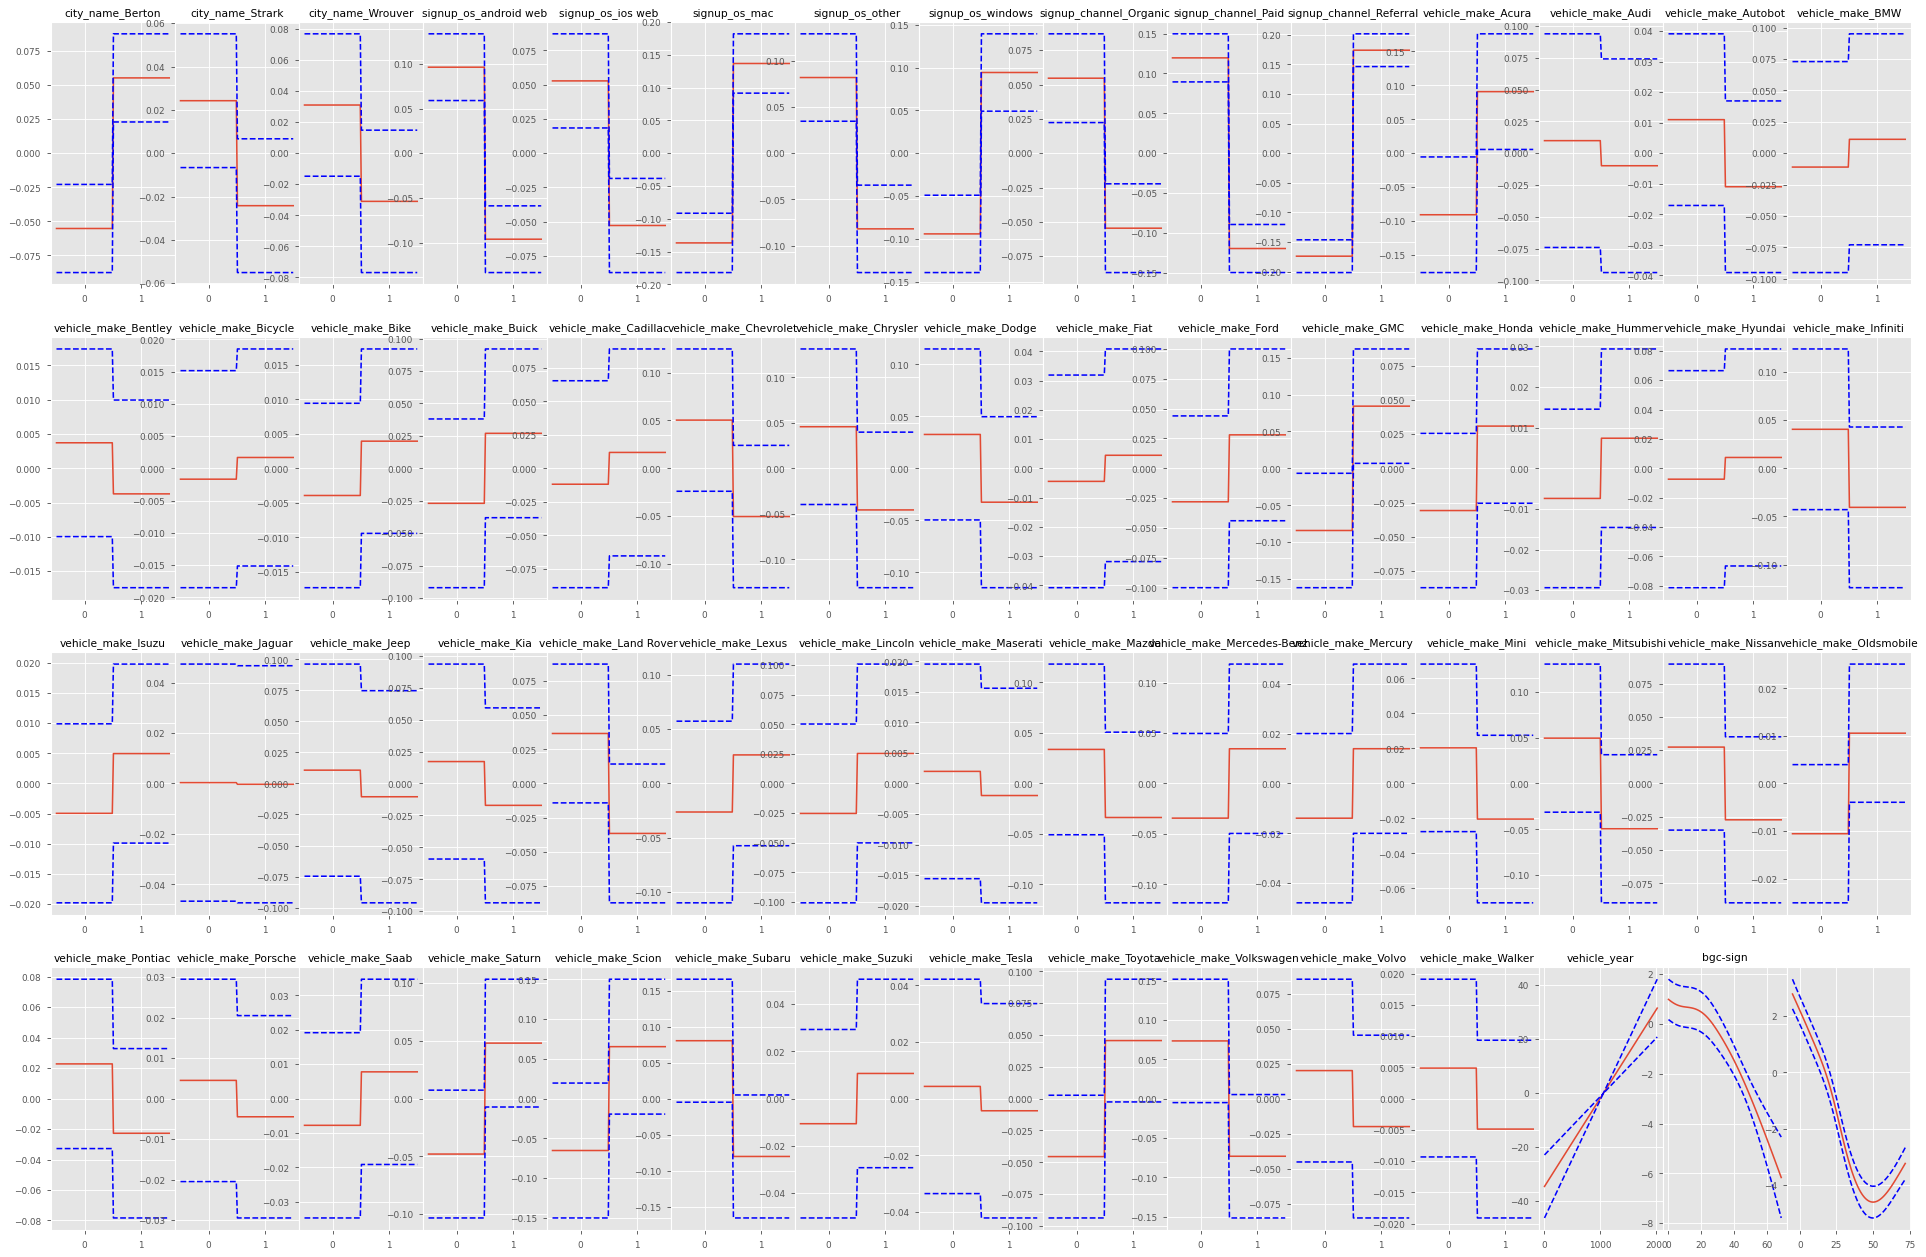

In [ ]:
titles = [X_train.columns[i] for i in range(59)]
t = 0
fig, axs = plt.subplots(4,15,figsize = (30,20),dpi =80)
plt.style.use('seaborn-paper')
plt.subplots_adjust(wspace =0.0, hspace =0.2)#调整子图间距

for i in range(4):
    for j in range(15):
        if i==3:
            if j==14:
                pass
        XX = gam.generate_X_grid(term=t)
        pdep, confi = gam.partial_dependence(term=t, width=.95)
        axs[i][j].plot(XX[:, t], pdep)
        axs[i][j].plot(XX[:, t], confi, c='b', ls='--')
        axs[i][j].set_title(titles[t])
        t+=1
        
plt.savefig("gam.png")

In [ ]:
gam.accuracy(X_train.values,y_train.values)

0.9431497544152994

In [ ]:
res = gam.predict(X_test.values)

In [ ]:
(res==1).sum()

1988

Accuracy: 0.94
Precision: 0.73
Recall: 0.80
Average precision-recall score: 0.60
F1: 0.76
confusion matrix: [[46716  1828]
 [ 1251  4886]]


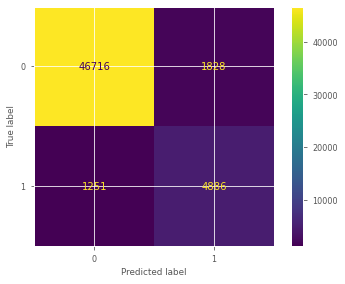

In [ ]:
report_evaluation_metrics(y,gam.predict(X))

In [ ]:
com_sign = pd.DataFrame(pd.to_datetime(data1['first_completed_date']) - pd.to_datetime(data1['signup_date']))/pd.Timedelta(1,'D')
data_prd['com-sign'] = com_sign


In [ ]:
data_prd = data_prd.dropna(how = 'any')

In [ ]:
data_prd 

,city_name_Berton,city_name_Strark,city_name_Wrouver,signup_os_android web,signup_os_ios web,signup_os_mac,signup_os_other,signup_os_windows,signup_channel_Organic,signup_channel_Paid,...,vehicle_make,vehicle_model,vehicle_year,first_completed_date,start,ifbgc,ifadd,bgc-sign,add-sign,com-sign
3,1,0,0,1,0,0,0,0,0,0,...,Toyota,Corolla,2016.0,2/3/16,1,1,1,5.0,5.0,5.0
6,0,1,0,0,1,0,0,0,0,1,...,Toyota,Prius V,2014.0,1/23/16,1,1,1,2.0,7.0,9.0
12,0,1,0,1,0,0,0,0,0,0,...,Kia,Optima,2015.0,1/28/16,1,1,1,0.0,0.0,16.0
15,0,1,0,0,0,0,0,1,0,0,...,Toyota,Prius V,2015.0,1/16/16,1,1,1,2.0,2.0,1.0
43,1,0,0,1,0,0,0,0,0,0,...,Toyota,Corolla,2015.0,2/4/16,1,1,1,1.0,3.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54273,1,0,0,0,0,1,0,0,0,0,...,Toyota,Corolla,2013.0,1/15/16,1,1,1,3.0,9.0,10.0
54277,1,0,0,0,1,0,0,0,0,1,...,Hyundai,Elantra,2013.0,1/27/16,1,1,1,6.0,11.0,11.0
54289,0,1,0,0,1,0,0,0,0,0,...,Honda,Civic,2016.0,1/20/16,1,1,1,0.0,2.0,2.0
54290,1,0,0,1,0,0,0,0,0,0,...,Honda,Civic,2013.0,1/18/16,1,1,1,2.0,5.0,5.0


In [ ]:
X = data_prd.drop([])

In [ ]:

X = data_prd.drop(['id','city_name','signup_os','signup_channel','signup_date','bgc_date','vehicle_added_date','vehicle_make','vehicle_model','first_completed_date','start','ifbgc','ifadd','com-sign'],axis=1)
y = data_prd['com-sign']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

In [ ]:
model = linear_model.LinearRegression().fit(X,y)
model.score(X_test,y_test)

0.44416506668533073

In [ ]:
import statsmodels.api as sm
x = sm.add_constant(X) # 若模型中有截距，必须有这一步
model = sm.OLS(y, x).fit() # 构建最小二乘模型并拟合
print(model.summary()) # 输出回归结果


                            OLS Regression Results                            
Dep. Variable:               com-sign   R-squared:                       0.442
Model:                            OLS   Adj. R-squared:                  0.437
Method:                 Least Squares   F-statistic:                     85.48
Date:                Sun, 30 May 2021   Prob (F-statistic):               0.00
Time:                        16:38:47   Log-Likelihood:                -18614.
No. Observations:                5872   AIC:                         3.734e+04
Df Residuals:                    5817   BIC:                         3.771e+04
Df Model:                          54                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               